# Method 1: Using Pystan

I'll do this for a single n, and treat the mode locations as fixed for now.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from astropy.units import cds
from astropy import units as u
import corner
import matplotlib
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('axes',labelsize=20)


#The stellar parameters are for 16 Cyg A
nus = 0.411 #uHz
i = np.deg2rad(56.) #rad
d02 = 6.8 #uHz
dnu = 102. #uHz

In [2]:
locs = np.genfromtxt('locs.txt')
l0 = locs[int(np.floor(len(locs)/2)+1), 0]
l1 = locs[int(np.floor(len(locs)/2)), 1] + dnu
l2 = locs[int(np.floor(len(locs)/2)), 2]
l3 = locs[int(np.floor(len(locs)/2)-1), 3] + dnu
ff = np.genfromtxt('freqs.txt')
pp = np.genfromtxt('model.txt')

In [3]:
sel = [(ff >= l0 - 0.3*dnu) & (ff <= l0 + 0.7*dnu)]
print(l0 - 2.0*d02)
print(l0 + 0.6*dnu)
print(dnu)
f = ff[tuple(sel)]
p = pp[tuple(sel)] 


2283.8462474355574
2358.646247435557
102.0


804


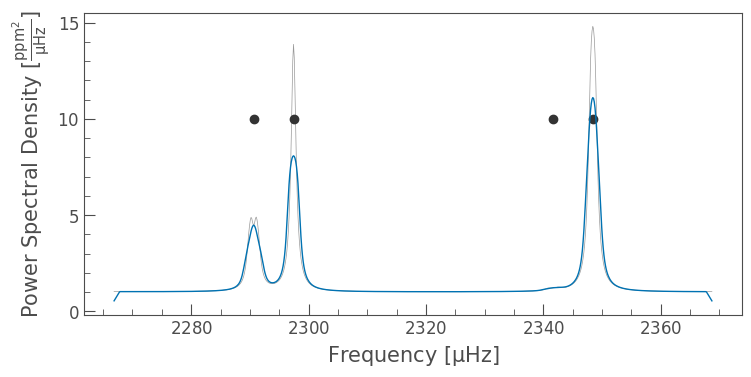

In [4]:
pg = lk.Periodogram(f*u.microhertz, p*(cds.ppm**2/u.microhertz))
ax = pg.plot(alpha=.5)
pg.smooth(filter_width=2.).plot(ax=ax, linewidth=1)
lev = 10
modes = [l0,l1,l2,l3]
plt.scatter(modes,[lev for n in modes])
print(len(pg.power))

1.0217826566130224


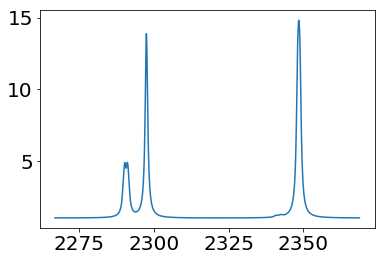

In [32]:
fig, ax = plt.subplots()
ax.plot(f, p)
print(p[1])

Lets fit a group of lorentzians to these data!

In [33]:
import pystan
model = '''
functions{
    real lor(real f, real nu0, real h, real w){
        return h / (1.0 + (4.0 / w^2) * (f - nu0)^2);
    }
}
data{
    int N; // Number of data points
    int M; // Number of modes
    real f[N];
    real p[N];
    real degree[M];
    real dnu;
    real first_guess[M]; 
}
parameters{
    real background;
    real logAmp[M]; // Log Amplitude
    real logGamma[M]; // log linewidth
    vector[M] nu0; // Frequencies 
    real split; // Rotational splitting
    vector[6] mratio; // m component heights as a result of angle of inc
}
transformed parameters{
    real H[M]; // Mode height
    real w[M]; // Mode linewidth
    for (i in 1:M){
        w[i] = 10^logGamma[i];
        H[i] = 10^logAmp[i] / w[i];
    }
}
model{
    real mult[N];
    for (i in 1:N){
        mult[i] = background;
        for (deg in 1:M){
            for (az in 0:l){
                mult[i] += lor(f[i], nu0[deg], H[deg], w[deg]);
            }
        }
    }
    mult ~ normal(p, 0.1);
    
    //priors on the parameters;
    logAmp ~ normal(1, 1);
    logGamma ~ normal(0,0.1);
    nu0 ~ normal(first_guess, 1);
    background ~ normal(1, 0.1);
}
'''
sm = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a18b79c8f712cd61976a1bd014c65894 NOW.


In [34]:
M_modes = len(modes)
data = {'N':len(f),
        'M': M_modes,
        'f':f,
        'p':p,
        'dnu': dnu, 
        'first_guess': np.sort(modes)}
start = {'logAmp': np.ones(M_modes),
        'logGamma':np.zeros(M_modes),
        'nu0': np.sort(modes)}
print(start)

{'logAmp': array([1., 1., 1., 1.]), 'logGamma': array([0., 0., 0., 0.]), 'nu0': array([2290.64624744, 2297.44624744, 2341.64624744, 2348.44624744])}


In [35]:
nchains = 4
fit = sm.sampling(data=data, iter=500, chains=nchains, init=[start for n in range(nchains)])

/home/davies/.local/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [36]:
print(fit)

Inference for Stan model: anon_model_a18b79c8f712cd61976a1bd014c65894.
4 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
background    0.96  1.2e-4 3.9e-3   0.96   0.96   0.96   0.97   0.97   1000    1.0
logAmp[0]     0.92  1.3e-4 4.0e-3   0.92   0.92   0.92   0.93   0.93   1000    1.0
logAmp[1]     1.11  6.0e-5 1.9e-3    1.1    1.1   1.11   1.11   1.11   1000    1.0
logAmp[2]    -0.86  9.4e-3   0.17  -1.28  -0.94  -0.84  -0.75   -0.6    327   1.02
logAmp[3]     1.32  4.4e-5 1.4e-3   1.32   1.32   1.32   1.32   1.32   1000    1.0
logGamma[0]    0.3  1.6e-4 5.2e-3   0.29    0.3    0.3   0.31   0.31    995    1.0
logGamma[1]-2.9e-3  8.4e-5 2.7e-3-8.2e-3-4.5e-3-3.0e-3-1.1e-3 2.4e-3   1000    1.0
logGamma[2]   0.04  3.9e-3   0.09  -0.16  -0.02   0.03   0.09   0.21    521   1.01
logGamma[3]   0.15  6.0e-5 1.9e-3   0.14   0.15   0.15   0.15   0.1

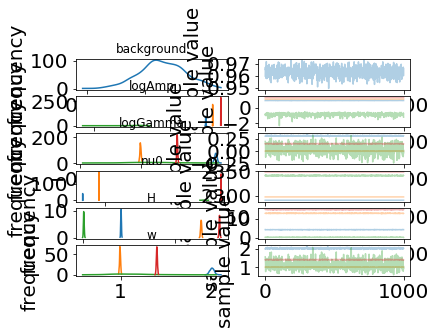

In [37]:
fit.plot()
plt.show()

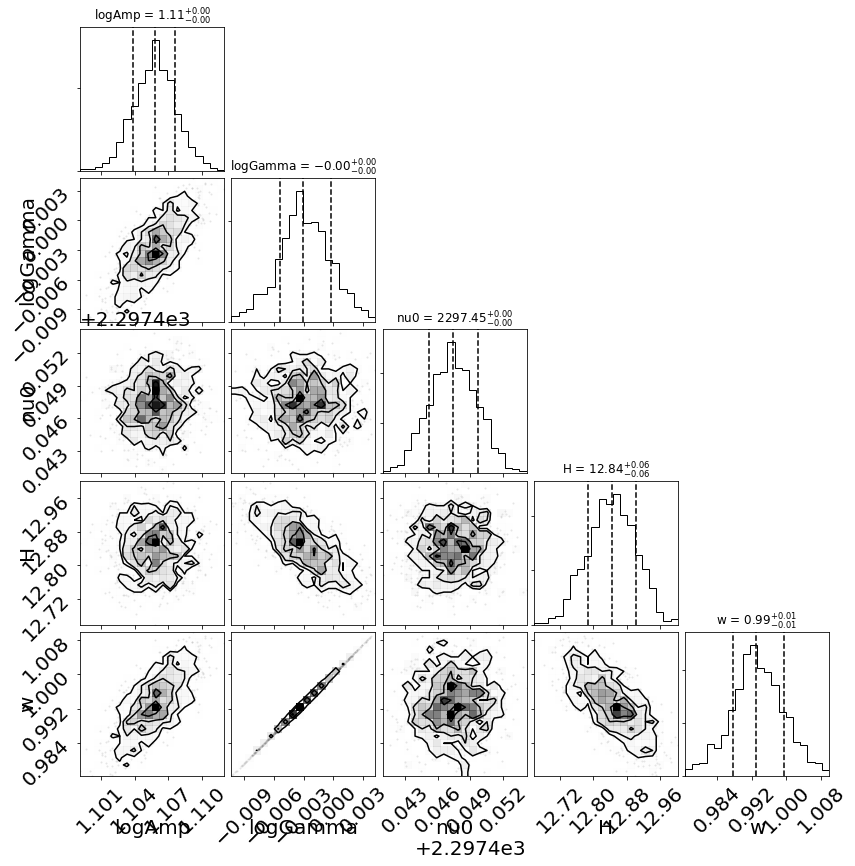

In [41]:
labels=['logAmp','logGamma', 'nu0', 'H', 'w']
chain = np.array([fit[label][:, 1] for label in labels])
corner.corner(chain.T, labels=labels, quantiles=[0.16, 0.5, 0.84],
            show_titles=True)
plt.show()